# 인물사진
## exploration 5

### 목표
---
1. 인물모드 구현
    1. 3장 이상의 사진 사용    
2. 사용한 사진에서 문제점 찾기
    1. 이미지에 문제점 표시
3. 해결 방안 제시

### 프로그래밍 방향
---
1. 세그멘테이션 모델 준비
2. 이미지 세그멘테이션 적용 및 인물모드 만들기
3. 결과 확인

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 1. 세그멘테이션 모델 준비

In [2]:
# 모델 준비
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [3]:
# 인물 컬러
person_color = np.array([128, 128, 192])
person_color

array([128, 128, 192])

## 2. 이미지 세그멘테이션 적용 및 인물모드 만들기

In [4]:
# 폴더안 이미지 불러오기
image_folder_path = 'image'
image_names = os.listdir(image_folder_path)
image_names

['2.jpg', '6.jpg', '4.jpg', '3.jpg', '1.jpg', '5.jpg']

In [5]:
def person_mode(img_path, img_check=False):
    img = cv2.imread(img_path) 
    img_show = img.copy()
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # 인물 추출하기
    
    # 인물 컬러만 추출하기 위한 맵 준비
    seg_map = np.all(output==person_color, axis=-1) 
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255
           
    # 이미지 확인
    if img_check:
        # 255와 0을 적당한 색상으로 바꿔봅니다
        color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
        # 원본 이미지와 마스크를 6:4로 합치기 
        img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
        plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
        plt.show()
    
    # 불러처리된 배경만들기
    
    # 이미지 불러처리
    img_orig_blur = cv2.blur(img, (13,13))
    # BGR 형식을 RGB 형식으로 변경
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

    # cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
    # 연산을 하고 나면 배경은 255 사람은 0입니다.
    img_bg_mask = cv2.bitwise_not(img_mask_color)

    # cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
    # 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
    # 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다.
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    # 배경 이미지 확인
    if img_check:
        plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
        plt.show()
    
    # 인물과 흐려진 배경이 합쳐진 결과 리턴
    return np.where(img_mask_color==255, img, img_bg_blur)

## 3. 결과 확인 

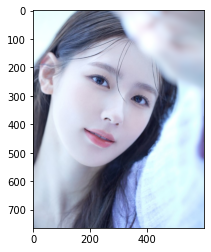

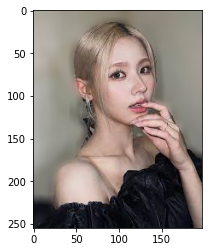

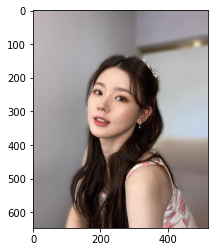

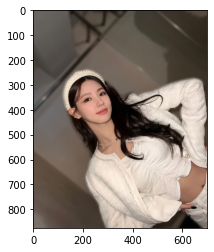

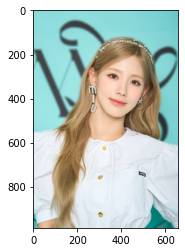

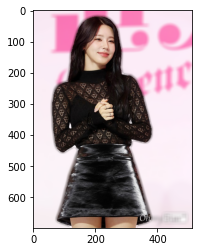

In [6]:
for image_name in image_names:
    # 이미지 경로
    image_path = image_folder_path + '/' + image_name
    person_mode_image = person_mode(image_path)
    plt.imshow(cv2.cvtColor(person_mode_image, cv2.COLOR_BGR2RGB))
    plt.show()

## 문제점 찾기
---
![](result/1.png)
<center>대부분이 인물일 경우 신체 일부분이 인식되지 못함</center>

![](result/2.png)
<center>머리카락이 얽힌 상세한 부분이 제대로 인식되지 못함</center>

![](result/3.png)
<center>인물의 모자가 제대로 인식되지 못함</center>

## 문제점 해결 제시해보기
---
세그멘테이션 모델의 한계점으로 지금의 사진들을 보면
객체의 크기가 크거나 작은 경우 예측을 잘 하지 못하는 문제
Object의 디테일한 모습이 사라지는 문제
이렇게 2가지의 원인이 있는 것으로 보인다.

이를 보완하기 위하여 모델들이 제시되고 있는데
이와 별개로 특정 오브젝트의 중점을 둔다면 그 오브젝트에 중점을 둔 모델을 학습시켜야 한다고 생각된다.

모델로는
DeconvNet or segNet이 있는데 인코딩과 디코딩을 대칭으로 사용하여 서로 보완해주는 형태의 모델
Receptive field를 확장시킨 models로 인식범위를 크게하여 사용하는 모댈
들을 제시할 수 있을것 같다.